# Machine Learning Project : To bee or not to bee
___

## 1. Business Understanding

* Context : Pollinator insects such as bees and bumblebees are important for ecosystems diversity and by fertilizing flowers, they play a vital role in the global food chain system.
* Problem : Distinguishing bee types amongst pollinators is crucial in this context and traditional methods which are mostly manual are quite time-consuming especially with our dataset of 250 images, although it might be less prone to error
* Solution : This project aims to leverage Machine Learning (ML), Deep Learning and Ai & Optimization techniques to automate the identification process by looking at an image (and its mask) and recognize the bug type and in a later time its species.
* Stakeholders : This project would interest more than one amongst researches, within the agricultural sector as well as for educational purposes.

Now that we're well versed in the subject of this project we can get into the technicalities

## 2. Data Understanding

In [47]:
# We need to import the necessary libraries 

import cv2
import os
import numpy as np
from tqdm.notebook import tqdm 
import re
import matplotlib.pyplot as plt
from PIL import Image
from scipy.optimize import minimize
import scipy.ndimage as ndi
import datetime
from time import process_time
import glob
import pandas as pd
from skimage import measure
import scipy.ndimage as ndi

### Configuration

In [48]:
IMAGE_FOLDER = 'tobeeornottobee_train_v2/train' 
MASK_FOLDER = 'tobeeornottobee_train_v2/train/masks'  
MASK_FILE_EXTENSION = '.tif'
EXPECTED_TRAINING_FILES = 250
LABELS_PATH = 'tobeeornottobee_train_v2/train/classif.xlsx'

### Dataset Loading

In [49]:
training_data = [] # we will store each image and its mask identified by a unique ID (seq(0,250))

try:
    # list the files in IMAGE_FOLDER.
    all_files_in_image_folder = os.listdir(IMAGE_FOLDER)

    # keep only the .jpg files (filter out the /mask folder)
    image_filenames = [f for f in all_files_in_image_folder if f.lower().endswith('.jpg')]

    # sort the filenames numerically 
    # since our files aren't formatted such as 001, 002 if we keep them this way 100 will be before 2 
    def sort_key(filename):
        match = re.match(r'(\d+)\.jpg', filename, re.IGNORECASE) # find number (digits) before the extension
        return int(match.group(1))
    image_filenames.sort(key=sort_key)

    # make sure we have 250 files loaded so far
    files_to_load = image_filenames[:EXPECTED_TRAINING_FILES]
    if len(files_to_load) < EXPECTED_TRAINING_FILES:
         print(f"Warning: Loading {len(files_to_load)} files.")
    else:
         print(f"Loading the {len(files_to_load)} files based on sorted filenames.")

    for img_filename in tqdm(files_to_load, desc="Processing Files"):

        # getting the name that will serve as ID as well
        image_id = os.path.splitext(img_filename)[0]

        # creating full path to the image file
        image_path = os.path.join(IMAGE_FOLDER, img_filename)

        # finding expected filename for the corresponding mask.
        mask_filename = "binary_" + image_id + MASK_FILE_EXTENSION # e.g., "binary_1.tif"
        # creating full path to the mask file
        mask_path = os.path.join(MASK_FOLDER, mask_filename)
        
        # load the image using OpenCV (BGR format by default in OpenCV)
        image = cv2.imread(image_path)
        if image is None:
            print(f"  Warning: Could not read image file: '{image_path}'. Skipping this pair.") # check if loading works
            continue 

        # load the mask as Grayscale (single channel) using OpenCV
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"  Warning: Could not read mask file: '{mask_path}'. Skipping this pair.") # check if loading worked.
            continue

        # finallt, store the loaded data in our list.
        data_item = {
            'id': image_id,        # The identifier (e.g., '1', '123')
            'image': image,        # The loaded image 
            'mask': mask           # The loaded mask (corresponding to the image)
        }
        training_data.append(data_item)

    print(f"\nFinished loading. Successfully loaded {len(training_data)} image/mask pairs.")

except FileNotFoundError:
    print("Error in paths")
    training_data = [] # Ensure data list is empty if loading failed
except Exception as e:
    print("An unexpected error occurred")
    print(e)
    training_data = []

Loading the 250 files based on sorted filenames.


Processing Files:   0%|          | 0/250 [00:00<?, ?it/s]

[ WARN:0@11480.663] global loadsave.cpp:268 findDecoder imread_('tobeeornottobee_train_v2/train/masks/binary_154.tif'): can't open/read file: check file path/integrity



Finished loading. Successfully loaded 249 image/mask pairs.


### Feature Extraction

Defining helper functions derived from the AI & Optimization LAB 

However, We'll use ndi for rotation instead of matrixes to avoid time-consuming iterations

In [50]:
def rotate_image(theta_degree_scalar, xc, yc, binary_arr):
    rotated_mask = ndi.rotate(binary_arr, angle=theta_degree_scalar, reshape=False, 
                              mode='constant', cval=0, order=0) # order=0 for binary
    return (rotated_mask > 0.5).astype(np.uint8) # ensure binary output

In [51]:
def bb_loss(theta_degree, xc, yc, binary_arr): # xc, yc are for context
    s1, s2 = binary_arr.shape

    if isinstance(theta_degree, (np.ndarray, list, tuple)):
        current_theta = theta_degree[0] # Take the first element if it's an array/list
    else:
        current_theta = theta_degree    # Assume it's already a scalar

    # using faster ndi-based rotation instead of LAB1 logic from AI & Optimization
    rot_arr = rotate_image(current_theta, xc, yc, binary_arr) 

    [x_rot, y_rot] = np.where(rot_arr > 0)

    if len(x_rot) == 0: # if rotated mask is empty
        return float(s1 * s2) # max possible loss

    min_r, max_r = np.min(x_rot), np.max(x_rot)
    min_c, max_c = np.min(y_rot), np.max(y_rot)
    
    bb_rot_area = (max_r - min_r + 1) * (max_c - min_c + 1)
    loss = float(bb_rot_area - np.sum(rot_arr)) # Area of bbox - area of rotated mask
    return loss

Main logic for feature extraction to implement 

In [52]:
def extract_features(image_id, image_rgb_arr_input, mask_binary_arr_input):
    features = {'id': image_id}
    boolean_mask = mask_binary_arr_input.astype(bool)
    num_bug_pixels = np.sum(mask_binary_arr_input)
    feature_names = [
        'shape_eccentricity', 'shape_solidity', 'pixel_ratio_bug_to_total',
        'R_min', 'R_max', 'R_mean', 'R_median', 'R_std',
        'G_min', 'G_max', 'G_mean', 'G_median', 'G_std',
        'B_min', 'B_max', 'B_mean', 'B_median', 'B_std',
        'bug_area', 'bbox_aspect_ratio',
        'centroid_x', 'centroid_y', 
        'optimal_angle', 
        'oriented_bbox_area', 
        'oriented_bbox_aspect_ratio', 
        'mask_area_to_oriented_bbox_area_ratio', 
        'hu_moment_1', 'hu_moment_2', 
        'contour_complexity_approx'
    ]
    for name in feature_names: features[name] = np.nan
    features['pixel_ratio_bug_to_total'] = 0.0 
    features['bug_area'] = 0
    if num_bug_pixels == 0:
        print(f"Warning: Mask for image {image_id} is effectively empty.")
        return features 
    features['bug_area'] = num_bug_pixels
    label_img_sk = measure.label(mask_binary_arr_input)
    props_list_sk = measure.regionprops(label_img_sk, intensity_image=image_rgb_arr_input)
    if props_list_sk:
        bug_props_sk = props_list_sk[0]
        features['shape_eccentricity'] = bug_props_sk.eccentricity
        features['shape_solidity'] = bug_props_sk.solidity
        minr, minc, maxr, maxc = bug_props_sk.bbox
        bbox_height = maxr - minr 
        bbox_width = maxc - minc  
        features['bbox_aspect_ratio'] = bbox_height / bbox_width if bbox_width > 0 else np.nan
    total_pixels = image_rgb_arr_input.shape[0] * image_rgb_arr_input.shape[1]
    if total_pixels > 0 :
        features['pixel_ratio_bug_to_total'] = num_bug_pixels / total_pixels
    for i, color_char in enumerate(['R', 'G', 'B']):
        channel_pixels = image_rgb_arr_input[:, :, i][boolean_mask]
        if channel_pixels.size > 0: 
            features[f'{color_char}_min'] = np.min(channel_pixels)
            features[f'{color_char}_max'] = np.max(channel_pixels)
            features[f'{color_char}_mean'] = np.mean(channel_pixels)
            features[f'{color_char}_median'] = np.median(channel_pixels)
            features[f'{color_char}_std'] = np.std(channel_pixels)
    [rows, cols] = np.where(mask_binary_arr_input > 0)
    xc_mask = np.mean(rows) 
    yc_mask = np.mean(cols)
    features['centroid_x'] = xc_mask
    features['centroid_y'] = yc_mask
    try:
        test_angles = np.arange(0, 181, 45) 
        losses = [bb_loss(angle, xc_mask, yc_mask, mask_binary_arr_input) for angle in test_angles]
        initial_angle_guess = test_angles[np.argmin(losses)]
        res = minimize(bb_loss, initial_angle_guess, 
                       args=(xc_mask, yc_mask, mask_binary_arr_input),
                       method='Nelder-Mead', 
                       options={'xatol': 2e-1, 'fatol': 2e-1, 'maxiter': 10}) 
        current_optimal_angle = initial_angle_guess 
        if res.success or 'iteration limit' in res.message.lower() or 'tolerance' in res.message.lower():
            # Ensure res.x[0] is scalar for optimal_angle
            if isinstance(res.x, (np.ndarray, list, tuple)):
                current_optimal_angle = res.x[0] % 180
            else:
                current_optimal_angle = res.x % 180

        features['optimal_angle'] = current_optimal_angle
        rot_arr_optimal = rotate_image(current_optimal_angle, xc_mask, yc_mask, mask_binary_arr_input)
        [x_rot_opt, y_rot_opt] = np.where(rot_arr_optimal > 0)
        if len(x_rot_opt) > 0:
            min_r_opt, max_r_opt = np.min(x_rot_opt), np.max(x_rot_opt)
            min_c_opt, max_c_opt = np.min(y_rot_opt), np.max(y_rot_opt)
            oriented_bbox_h = max_r_opt - min_r_opt + 1 
            oriented_bbox_w = max_c_opt - min_c_opt + 1 
            obb_area = oriented_bbox_h * oriented_bbox_w
            features['oriented_bbox_area'] = obb_area
            features['oriented_bbox_aspect_ratio'] = oriented_bbox_h / oriented_bbox_w if oriented_bbox_w > 0 else np.nan
            mask_area_in_oriented_bbox = np.sum(rot_arr_optimal)
            if obb_area > 0:
                features['mask_area_to_oriented_bbox_area_ratio'] = mask_area_in_oriented_bbox / obb_area
    except Exception as e:
        print(f"Error during Lab01-style optimization for {image_id}: {e}.")
    moments = cv2.moments(mask_binary_arr_input) 
    hu_moments = cv2.HuMoments(moments).flatten()
    features['hu_moment_1'] = hu_moments[0] if len(hu_moments) > 0 else np.nan
    features['hu_moment_2'] = hu_moments[1] if len(hu_moments) > 1 else np.nan
    if props_list_sk: 
        contours, _ = cv2.findContours(mask_binary_arr_input.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
        if contours and len(contours) > 0: 
             main_contour = max(contours, key=cv2.contourArea) 
             if len(main_contour) > 1 : 
                 perimeter_cv = cv2.arcLength(main_contour, True)
                 if perimeter_cv > 0:
                     features['contour_complexity_approx'] = len(main_contour) / perimeter_cv
    return features

Feature extraction loop

In [53]:
all_extracted_features = []

if training_data: # check if data was loaded successfully
    print(f"\nStarting feature extraction for {len(training_data)} items...")
    for item in tqdm(training_data, desc="Extracting Features"):
        image_id_str = item['id']
        image_bgr_arr = item['image']       
        mask_grayscale_arr = item['mask']  

        # BGR to RGB 
        image_rgb_for_function = cv2.cvtColor(image_bgr_arr, cv2.COLOR_BGR2RGB)

        # binarize the grayscale mask
        mask_binary_for_function = (mask_grayscale_arr > 0).astype(np.uint8)
        
        # Extract features using the prepared image and mask
        features = extract_features(image_id_str, image_rgb_for_function, mask_binary_for_function)
        
        all_extracted_features.append(features)

    if all_extracted_features: # check if any features were actually extracted
        features_df = pd.DataFrame(all_extracted_features)

        print("--- Extracted Features (First 5 rows) ---")
        print(features_df.head())

        # in case i need to save to csv later features_df.to_csv("extracted_bee_project_features.csv", index=False)
    else:
        print("No features were extracted")

else:
    print("No data loaded")


Starting feature extraction for 249 items...


Extracting Features:   0%|          | 0/249 [00:00<?, ?it/s]

--- Extracted Features (First 5 rows) ---
  id  shape_eccentricity  shape_solidity  pixel_ratio_bug_to_total  R_min  \
0  1            0.392483        0.647039                  0.007428      5   
1  2            0.595418        0.565343                  0.008553      2   
2  3            0.240478        0.627267                  0.022093      3   
3  4            0.735380        0.608743                  0.013187      5   
4  5            0.650617        0.567071                  0.009165      6   

   R_max      R_mean  R_median      R_std  G_min  ...  bbox_aspect_ratio  \
0    208   68.085745      56.0  47.955399      3  ...           0.817073   
1    248   63.786498      55.0  42.153508      2  ...           0.660377   
2    255  107.176333     114.0  58.771359      0  ...           0.942857   
3    219   87.588243      88.0  46.322587      3  ...           0.764228   
4    255  123.177003     134.0  62.355944      0  ...           0.833333   

    centroid_x   centroid_y  optimal_a

In [ ]:
# Load label file
labels_df = pd.read_excel("tobeeornottobee_train_v2/train/classif.xlsx")  # update file path if needed

# Normalize column names
features_df.columns = [col.strip().lower().replace(' ', '_') for col in features_df.columns]
labels_df.columns = [col.strip().lower().replace(' ', '_') for col in labels_df.columns]

# Convert 'id' to string in both
features_df['id'] = features_df['id'].astype(str)
labels_df['id'] = labels_df['id'].astype(str)

# Merge both bug_type and species from label file
features_df = pd.merge(features_df, labels_df[['id', 'bug_type', 'species']], on='id')


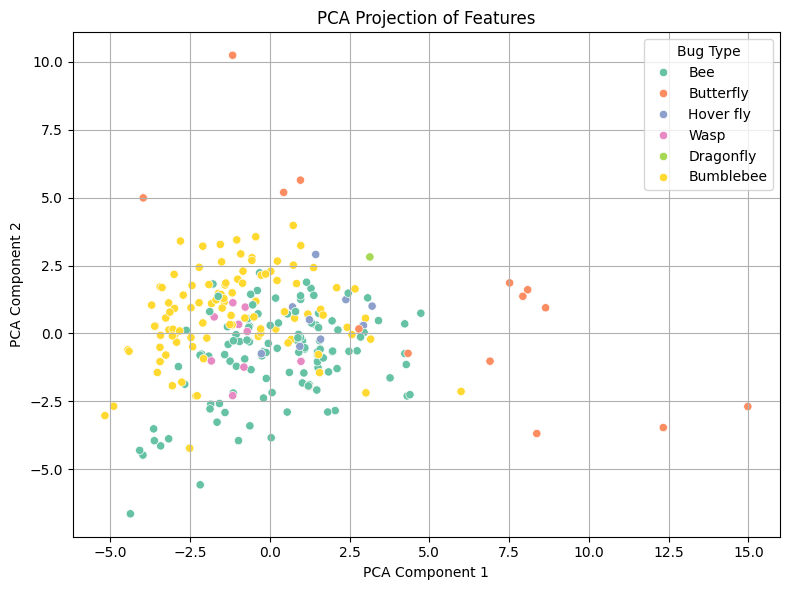

/Users/aziz/Documents/GitHub/to-bee-or-not-to-bee/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


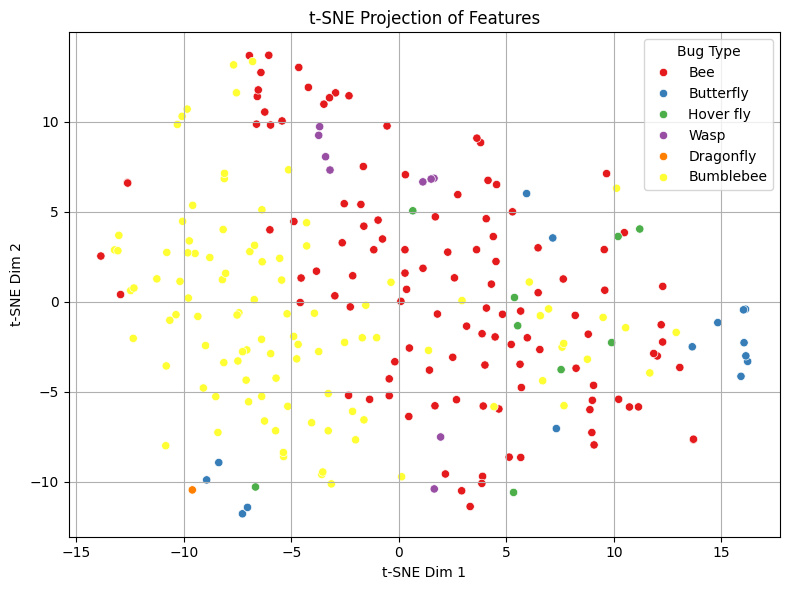

/Users/aziz/Documents/GitHub/to-bee-or-not-to-bee/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/aziz/Documents/GitHub/to-bee-or-not-to-bee/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


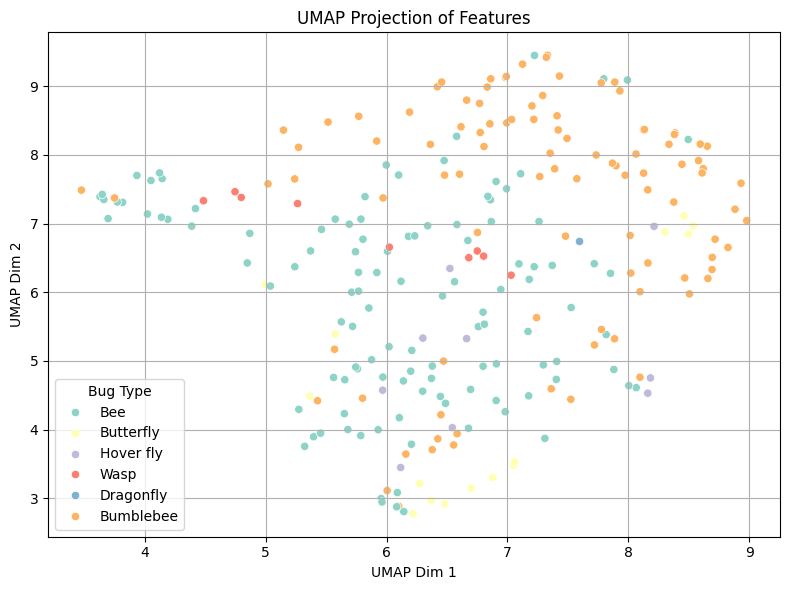

/var/folders/j4/2g8x3g1s6nv7pqn0480q4dr40000gn/T/ipykernel_5987/524833498.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features_df, x='bug_type', palette='pastel')


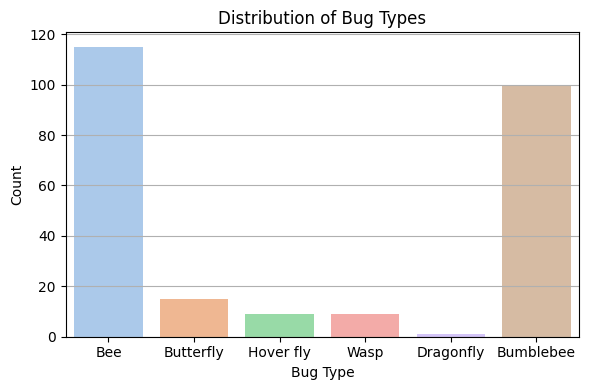

/var/folders/j4/2g8x3g1s6nv7pqn0480q4dr40000gn/T/ipykernel_5987/524833498.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features_df, x='species', palette='muted')


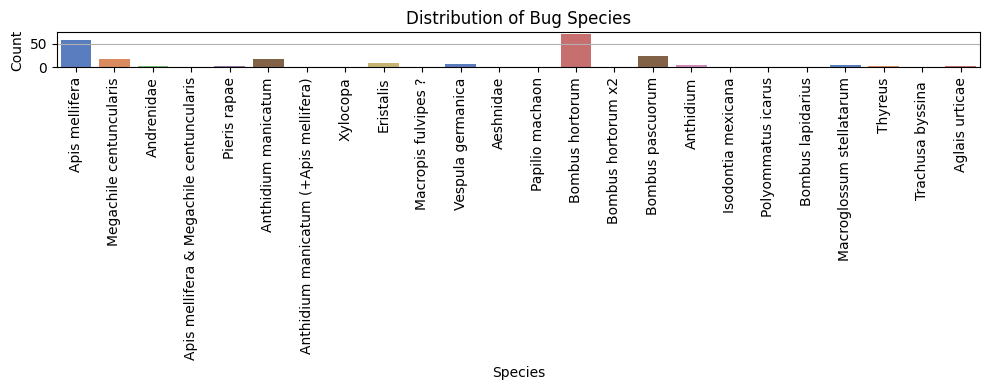

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap 
    

# Step 1: Prepare the feature matrix
feature_cols = [col for col in features_df.columns if col not in ['ID', 'bug_type', 'species']]

# Ensure only numeric features are included
X = features_df.select_dtypes(include='number')
y = features_df['bug_type']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------- PCA Plot ----------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set2')
plt.title("PCA Projection of Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Bug Type")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------- t-SNE Plot ----------------
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set1')
plt.title("t-SNE Projection of Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Bug Type")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------- UMAP Plot ----------------
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='Set3')
plt.title("UMAP Projection of Features")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Bug Type")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------- Bug Type Distribution ----------------
plt.figure(figsize=(6, 4))
sns.countplot(data=features_df, x='bug_type', palette='pastel')
plt.title("Distribution of Bug Types")
plt.xlabel("Bug Type")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ---------------- Species Distribution ----------------
plt.figure(figsize=(10, 4))
sns.countplot(data=features_df, x='species', palette='muted')
plt.title("Distribution of Bug Species")
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/Users/aziz/Documents/GitHub/to-bee-or-not-to-bee/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aziz/Documents/GitHub/to-bee-or-not-to-bee/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aziz/Documents/GitHub/to-bee-or-not-to-bee/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

=== Logistic Regression ===
Accuracy: 0.74
              precision    recall  f1-score   support

         Bee       0.83      0.83      0.83        30
   Bumblebee       0.71      0.67      0.69        15
   Butterfly       0.33      0.50      0.40         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.50      1.00      0.67         1

    accuracy                           0.74        50
   macro avg       0.48      0.60      0.52        50
weighted avg       0.74      0.74      0.74        50

=== Support Vector Machine (SVM) ===
Accuracy: 0.64
              precision    recall  f1-score   support

         Bee       0.75      0.70      0.72        30
   Bumblebee       0.53      0.67      0.59        15
   Butterfly       0.33      0.50      0.40         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.64        50
   macro avg       0.32      0.37   

/Users/aziz/Documents/GitHub/to-bee-or-not-to-bee/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aziz/Documents/GitHub/to-bee-or-not-to-bee/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aziz/Documents/GitHub/to-bee-or-not-to-bee/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

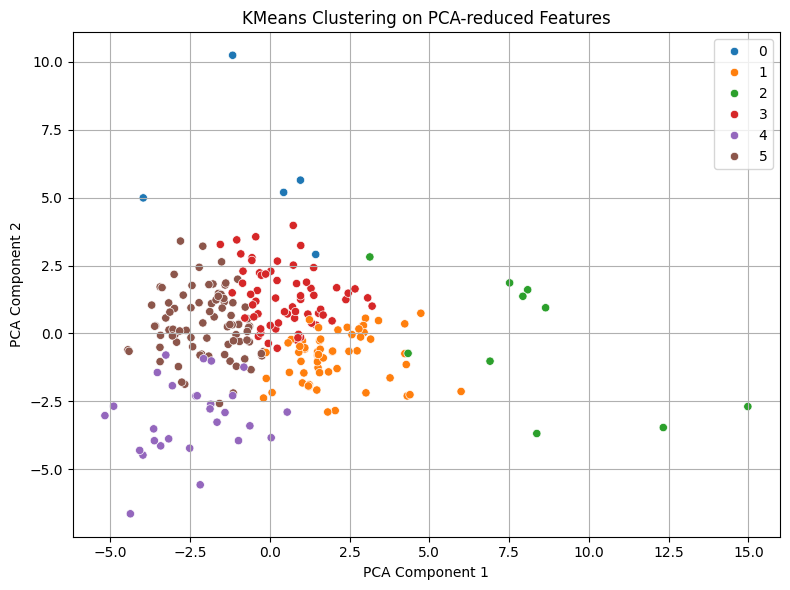

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------- Feature Selection -----------------
X = features_df.drop(columns=['id', 'bug_type', 'species'])
y = features_df['bug_type']

# ----------------- Train/Test Split -----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- Standardize -----------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------- Logistic Regression -----------------
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

# ----------------- SVM -----------------
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

print("=== Support Vector Machine (SVM) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# ----------------- Random Forest (Ensemble) -----------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("=== Random Forest (Ensemble) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# ----------------- KMeans Clustering -----------------
X_scaled = scaler.fit_transform(X)  # scale full data for clustering
kmeans = KMeans(n_clusters=len(y.unique()), random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot KMeans clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='tab10', legend='full')
plt.title("KMeans Clustering on PCA-reduced Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
